# Step 2-2 Univariate DL Models



In [54]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Conv1D, Flatten
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import warnings
import os

warnings.filterwarnings("ignore")

In [55]:
# Config
TARGET_VARIABLES = 'co2'
SELECTED_COUNTRIES = ['United States', 'China', 'India']
MAX_LAGS = 4
N_STEPS_IN = 5
N_STEPS_OUT = 1
TEST_SIZE = 9
save_dir = 'data/02_02_results'
os.makedirs(save_dir, exist_ok=True)

ARIMA_ORDERS = {
    'United States': (0, 1, 0),
    'China': (0, 2, 0),
    'India': (1, 1, 1)
}

In [56]:
DL_CONFIGS = {
    'LSTM': [
        {'hidden': 16, 'epochs': 100},
        {'hidden': 32, 'epochs': 100}
    ],
    'Bi-LSTM': [
        {'hidden': 8, 'epochs': 100},
        {'hidden': 16, 'epochs': 100}
    ],
    'ED-LSTM': [
        {'hidden': 8, 'epochs': 100},
        {'hidden': 16, 'epochs': 100}
    ],
    'CNN': [
        {'filters': 16, 'epochs': 100},
        {'filters': 32, 'epochs': 100}
    ]
}

In [57]:
def load_data(save_dir='data'):
    data_files = {
        'all_data_df': os.path.join(save_dir, 'all_data_df.csv'),
        'g20_lag_df': os.path.join(save_dir, 'g20_lag_df.csv'),
        'lag_three_sel_1969_df': os.path.join(save_dir, 'lag_three_sel_1969_df.csv')
    }

    dfs = {}
    for name, filepath in data_files.items():
        if os.path.exists(filepath):
            dfs[name] = pd.read_csv(filepath)
            print(f"Loaded {name}: {dfs[name].shape}")
        else:
            print(f"{filepath} not found")
    
    return dfs

In [58]:
data = load_data()
all_data_df = data['all_data_df']
g20_lag_df = data['g20_lag_df']
g20_lag_1969_df = g20_lag_df[g20_lag_df['year'] >= 1969].copy()
g20_lag_1969_df = g20_lag_1969_df[g20_lag_1969_df['year'] < 2023]
lag_three_sel_1969_df = data['lag_three_sel_1969_df']

Loaded all_data_df: (55529, 200)
Loaded g20_lag_df: (3744, 992)
Loaded lag_three_sel_1969_df: (162, 992)


In [59]:
# train_test_split
def tts_by_year(df, test_size=9):
    train_data = {}
    test_data = {}

    for country in df['country'].unique():
        country_data = df[df['country'] == country].sort_values('year')

        split_idx = len(country_data) - test_size
        train_data[country] = country_data.iloc[:split_idx]
        test_data[country] = country_data.iloc[split_idx:]

    train_df = pd.concat(train_data.values(), ignore_index=True)
    test_df = pd.concat(test_data.values(), ignore_index=True)

    return train_df, test_df

In [60]:
train_3_df, test_3_df = tts_by_year(lag_three_sel_1969_df, TEST_SIZE)
train_g20_df, test_g20_df = tts_by_year(g20_lag_1969_df, TEST_SIZE)

### Miscellaneous

In [61]:
def mase(y_actual, y_pred, period=1):
    mae_forecast = mean_absolute_error(y_actual, y_pred)

    naive_forecast = y_actual[:-period] if period > 0 else y_actual[:-1]
    actual_for_naive = y_actual[period:] if period > 0 else y_actual[1:]

    if len(naive_forecast) == 0:
        return np.nan
    
    mae_naive = mean_absolute_error(actual_for_naive, naive_forecast)

    if mae_naive == 0:
        return 0 if mae_forecast == 0 else np.inf
    
    return mae_forecast / mae_naive

In [62]:
def create_sequences(data, n_steps_in):
    X, y = [], []

    for i in range(len(data) - n_steps_in):
        X.append(data[i:i + n_steps_in])
        y.append(data[i + n_steps_in])
        
    return np.array(X), np.array(y)

### DL Model Builds

In [63]:
def build_lstm(input_shape, hidden=16):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return model

In [64]:
def build_bilstm(input_shape, hidden=8):
    model = Sequential([
        Bidirectional(LSTM(hidden, activation='relu', kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.01)),
                      input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return model

In [65]:
def build_edlstm(input_shape, hidden=8):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        RepeatVector(N_STEPS_OUT),
        LSTM(hidden, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return model

In [66]:
def build_cnn(input_shape, filters=16):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=2, activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=l2(0.01)),
        Flatten(),
        Dense(8, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return model

### Model Train and Forecast

In [67]:
def recursive_forecast(model, initial_sequence, n_steps, scaler):
    preds = []
    current_sequence = initial_sequence.copy()

    for step in range(n_steps):
        X_input = current_sequence.reshape(1, len(current_sequence), 1)

        pred_scaled = model.predict(X_input, verbose=0)

        # ED-LSTM change to single value
        if len(pred_scaled.shape) == 3:
            pred_scaled = pred_scaled[0, 0, 0]
        else:
            pred_scaled = pred_scaled[0, 0]
        
        preds.append(pred_scaled)

        # Update the seq (shift left and add the pred)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = pred_scaled

    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

    return preds.ravel()

In [ ]:
def train_eval_dl(train_country, test_country, target):
    # Data sort
    train_sorted = train_country.sort_values('year').reset_index(drop=True)
    test_sorted = test_country.sort_values('year').reset_index(drop=True)

    # Target
    train_data = train_sorted[target].values
    test_data = test_sorted[target].values

    # Data Scale with StandardScaler
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).ravel()

    # Create sequences
    X, y = create_sequences(train_scaled, N_STEPS_IN)

    # Reshape (samples, timesteps, features)
    X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

    # Model info
    dl_models = {
        'LSTM': build_lstm,
        'Bi-LSTM': build_bilstm,
        'ED-LSTM': build_edlstm,
        'CNN': build_cnn
    }

    results = {}

    # Train
    for model_name, model_func in dl_models.items():
        print(f"\nTraining {model_name} with hyperparameter tuning")

        best_rmse = np.inf
        best_config = None
        best_forecast = None

        for config in DL_CONFIGS[model_name]:
            # Extract epochs
            epochs = config['epochs']
            config_params = {k: v for k, v in config.items() if k != 'epochs'}
            
            # Build model with specific hyperparameters
            input_shape = (X_reshaped.shape[1], X_reshaped.shape[2])
            if model_name == 'CNN':
                model = model_func(input_shape, filters=config_params['filters'])
            else:
                model = model_func(input_shape, hidden=config_params['hidden'])

            model.fit(
                X_reshaped, y,
                epochs=epochs,
                batch_size=8,
                verbose=0
            )

            initial_sequence = train_scaled[-N_STEPS_IN:]

            n_forecast = len(test_data)
            forecast = recursive_forecast(model, initial_sequence, n_forecast, scaler)
            
            # Evaluate
            rmse_score = np.sqrt(mean_squared_error(test_data, forecast))
            
            print(f"    Config {config}: RMSE = {rmse_score:.4f}")

            if rmse_score < best_rmse:
                best_rmse = rmse_score
                best_config = config
                best_forecast = forecast
            
            # Clear memory
            tf.keras.backend.clear_session()
            del model

        mase_score = mase(test_data, best_forecast)
        
        results[model_name] = {
            'forecast': best_forecast,
            'RMSE': best_rmse,
            'MASE': mase_score,
            'best_config': best_config
        }
        
        print(f"    Best {model_name} - Config: {best_config}, RMSE: {best_rmse:.2f}, MASE: {mase_score:.4f}")

    return results

### ARIMA for comparison

In [ ]:
def train_arima(train_country, test_country, target, order):
    train_sorted = train_country.sort_values('year')
    test_sorted = test_country.sort_values('year')
    
    y_train = train_sorted[target].values
    y_test = test_sorted[target].values

    model = ARIMA(y_train, order=order)
    fitted_model = model.fit()
    
    # Forecast (ARIMA uses recursive strategy internally)
    forecast = fitted_model.forecast(steps=len(y_test))
    
    rmse = np.sqrt(mean_squared_error(y_test, forecast))
    mase_score = mase(y_test, forecast)
    
    print(f"    ARIMA - RMSE: {rmse:.2f}, MASE: {mase_score:.4f}")
    
    return {
        'forecast': forecast,
        'RMSE': rmse,
        'MASE': mase_score
    }

### Comparison

In [70]:
all_results = {}

for country in SELECTED_COUNTRIES:
    print(f"\n{country.upper()}")

    train_country = train_3_df[train_3_df['country'] == country]
    test_country = test_3_df[test_3_df['country'] == country]

    # Train arima with optimal orders
    arima_order = ARIMA_ORDERS[country]
    arima_result = train_arima(train_country, test_country, TARGET_VARIABLES, arima_order)

    # Train dl models
    dl_results = train_eval_dl(train_country, test_country, TARGET_VARIABLES)

    # Combine results
    if arima_result:
        dl_results['ARIMA'] = arima_result
    
    all_results[country] = dl_results


UNITED STATES
      ARIMA - RMSE: 356.26, MASE: 1.5207

Training LSTM with hyperparameter tuning
    Config {'hidden': 16, 'epochs': 100}: RMSE = 607.7456
    Config {'hidden': 32, 'epochs': 100}: RMSE = 690.7180
    Best LSTM - Config: {'hidden': 16, 'epochs': 100}, RMSE: 607.75, MASE: 2.7817

Training Bi-LSTM with hyperparameter tuning
    Config {'hidden': 8, 'epochs': 100}: RMSE = 569.4292
    Config {'hidden': 16, 'epochs': 100}: RMSE = 600.5669
    Best Bi-LSTM - Config: {'hidden': 8, 'epochs': 100}, RMSE: 569.43, MASE: 2.6639

Training ED-LSTM with hyperparameter tuning
    Config {'hidden': 8, 'epochs': 100}: RMSE = 243.6222
    Config {'hidden': 16, 'epochs': 100}: RMSE = 245.7884
    Best ED-LSTM - Config: {'hidden': 8, 'epochs': 100}, RMSE: 243.62, MASE: 0.9545

Training CNN with hyperparameter tuning
    Config {'filters': 16, 'epochs': 100}: RMSE = 656.6736
    Config {'filters': 32, 'epochs': 100}: RMSE = 622.2461
    Best CNN - Config: {'filters': 32, 'epochs': 100}, RM

In [71]:
summary_data = []

for country in SELECTED_COUNTRIES:
    for model_name, result in all_results[country].items():
        summary_data.append({
            'Country': country,
            'Model': model_name,
            'RMSE': result['RMSE'],
            'MASE': result['MASE']
        })

summary_df = pd.DataFrame(summary_data)

# RMSE pivot table: Models (rows) x Countries (columns)
rmse_pivot = summary_df.pivot(index='Model', columns='Country', values='RMSE')
rmse_pivot = rmse_pivot.round(2)

# Reorder models
model_order = ['ARIMA', 'LSTM', 'Bi-LSTM', 'ED-LSTM', 'CNN']
rmse_pivot = rmse_pivot.reindex([m for m in model_order if m in rmse_pivot.index])

print("\nRMSE Comparison by Model and Country:")
print(rmse_pivot)


RMSE Comparison by Model and Country:
Country    China    India  United States
Model                                   
ARIMA     429.38    99.10         356.26
LSTM     5430.47  1379.38         607.75
Bi-LSTM  5556.95  1551.54         569.43
ED-LSTM  6162.63  1629.54         243.62
CNN      2699.29   491.65         622.25


### Visualise and save

In [72]:
md_filepath = os.path.join(save_dir, 'baseline_model_comparison.md')

with open(md_filepath, 'w') as f:
    f.write("# Baseline Model Comparison\n\n")
    f.write("---\n\n")

    f.write("## Methodology\n\n")
    f.write("- **Input**: 5 year steps of CO2 data\n")
    f.write("- **Output**: Forecast 1 year step\n")
    f.write("- **Forecasting Strategy for DL models**: Recursive taken to compare with ARIMA\n")
    f.write("- **Test Period**: 9 years\n\n")

    f.write("## RMSE Results by Model and Country\n\n")
    f.write(rmse_pivot.to_markdown())
    f.write("\n\n")

    f.write("## Best Model Per Country (by RMSE)\n\n")
    for country in SELECTED_COUNTRIES:
        country_data = summary_df[summary_df['Country'] == country]
        best = country_data.loc[country_data['RMSE'].idxmin()]
        f.write(f"- **{country}**: {best['Model']} (RMSE: {best['RMSE']:.2f}, MASE: {best['MASE']:.4f})\n")


Creating plot for UNITED STATES

Creating plot for CHINA

Creating plot for INDIA


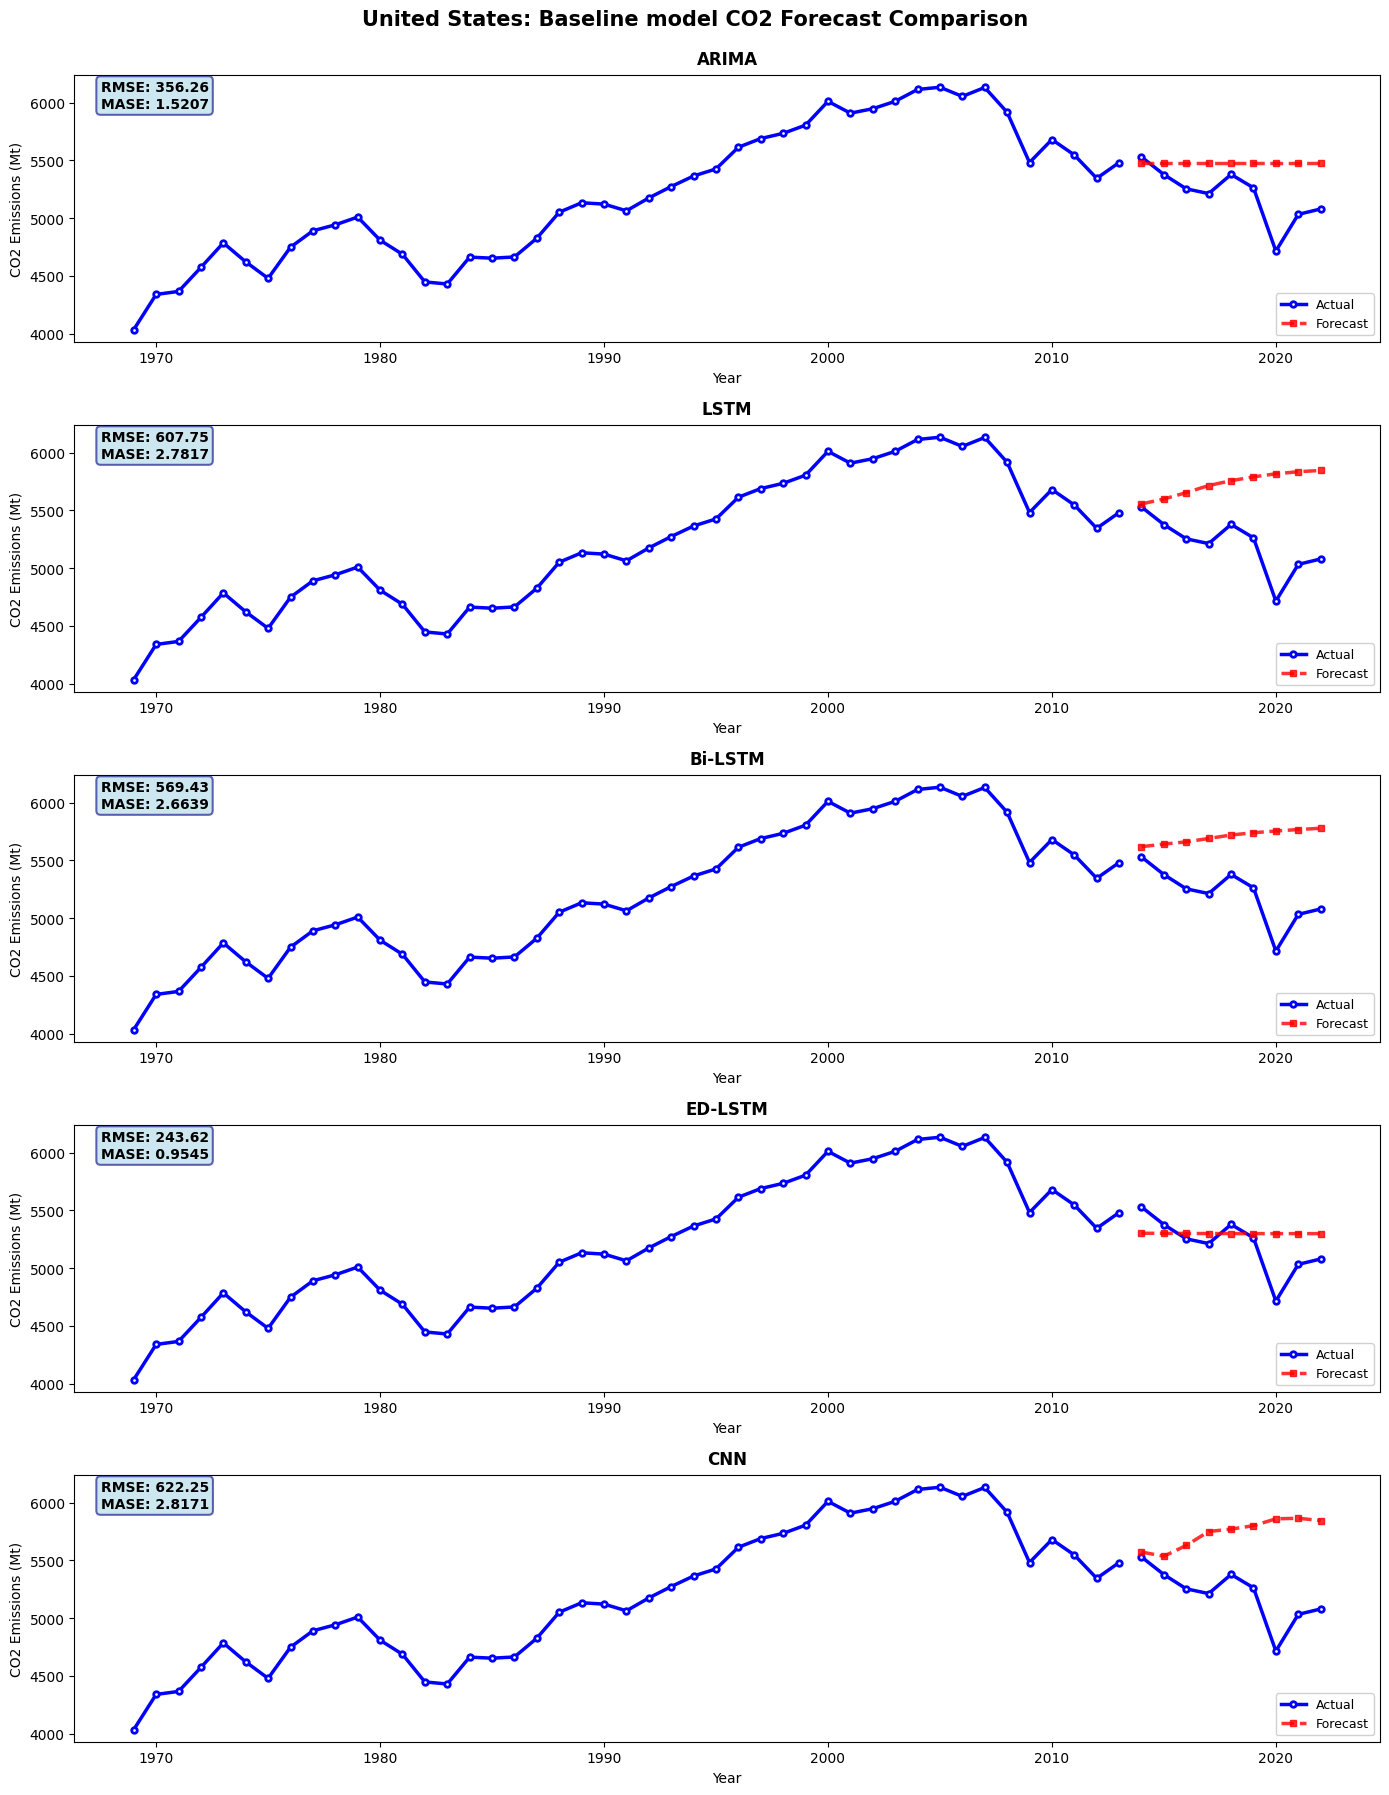

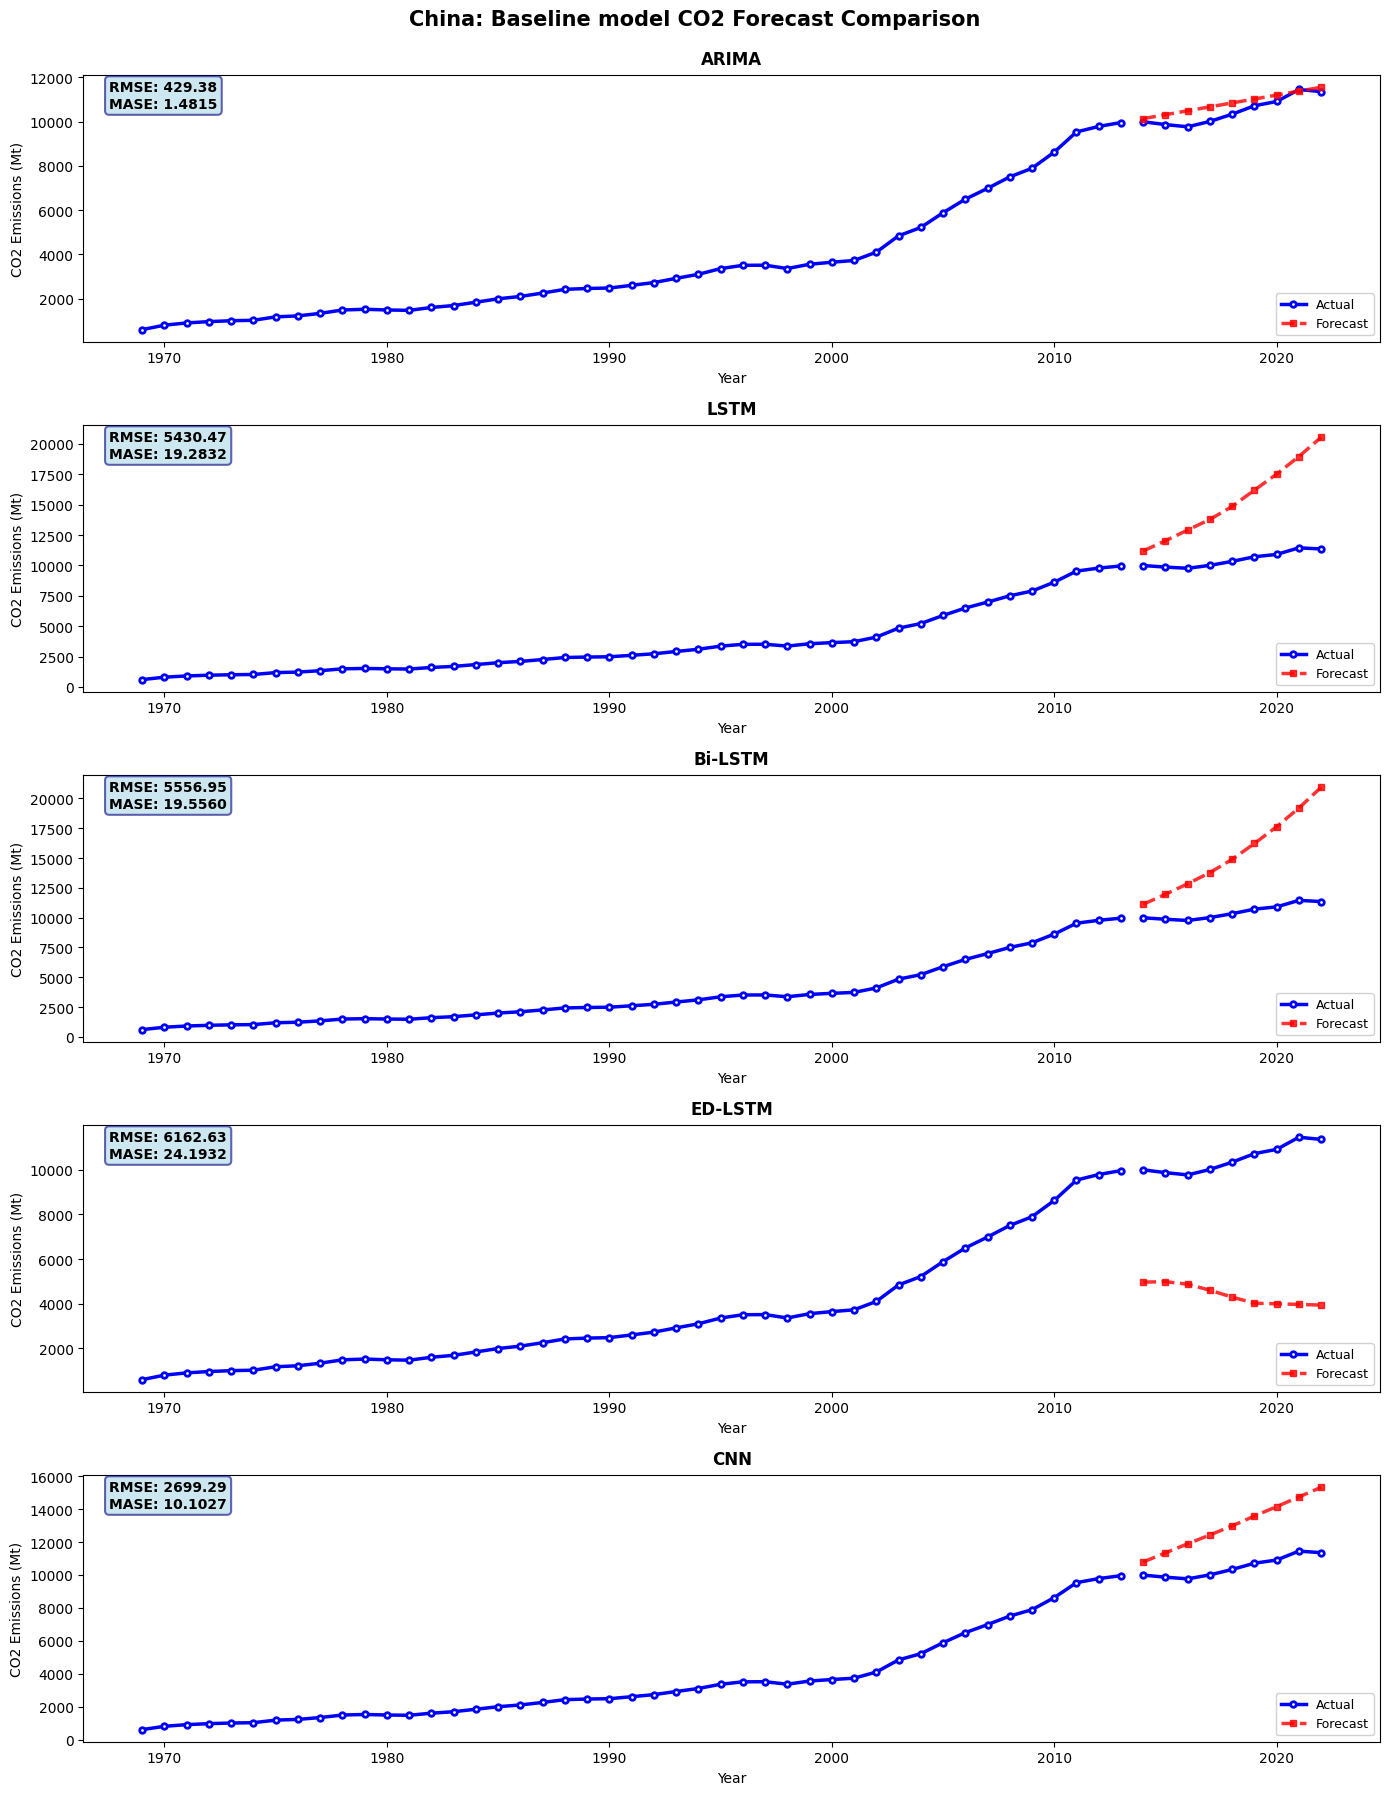

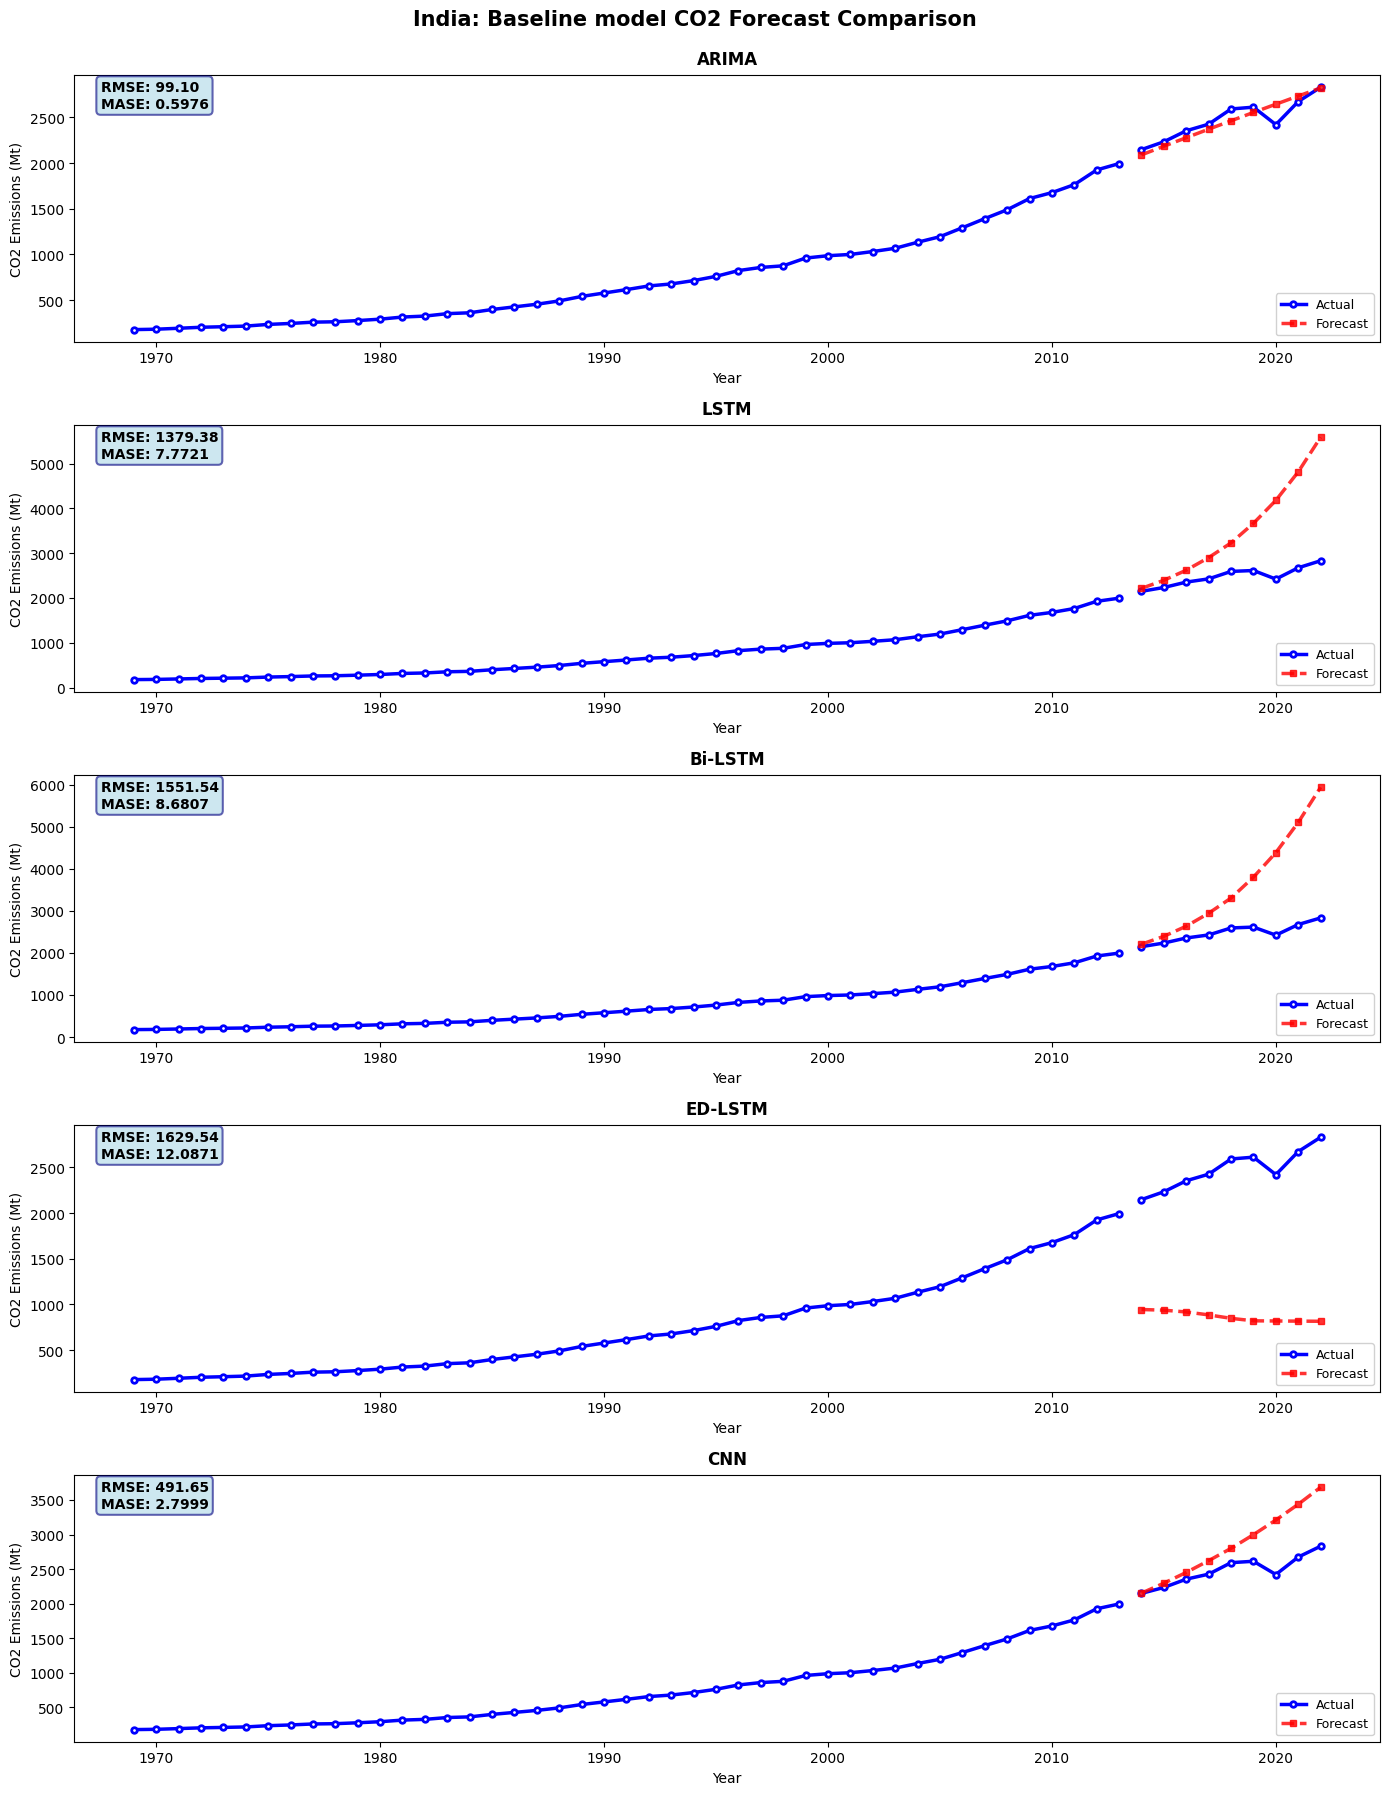

In [73]:
colors = {'actual': 'blue', 'forecast': 'red'}
models_to_plot = ['ARIMA', 'LSTM', 'Bi-LSTM', 'ED-LSTM', 'CNN']

for country in SELECTED_COUNTRIES:
    print(f"\nCreating plot for {country.upper()}")
    
    train_country = train_3_df[train_3_df['country'] == country].sort_values('year')
    test_country = test_3_df[test_3_df['country'] == country].sort_values('year')
    
    fig, axes = plt.subplots(5, 1, figsize=(14, 18))
    
    for idx, model_name in enumerate(models_to_plot):
        ax = axes[idx]
        
        ax.plot(train_country['year'], train_country[TARGET_VARIABLES], 
                color=colors['actual'], linewidth=2.5, label='Actual', 
                marker='o', markersize=4, markerfacecolor='white',
                markeredgewidth=2, markeredgecolor=colors['actual'])
        
        ax.plot(test_country['year'], test_country[TARGET_VARIABLES], 
                color=colors['actual'], linewidth=2.5, 
                marker='o', markersize=4, markerfacecolor='white',
                markeredgewidth=2, markeredgecolor=colors['actual'])
        
        if model_name in all_results[country]:
            result = all_results[country][model_name]
            forecast = result['forecast']
            rmse = result['RMSE']
            mase_score = result['MASE']
            
            ax.plot(test_country['year'], forecast,
                   color=colors['forecast'], linewidth=2.5, linestyle='--',
                   label='Forecast', marker='s', markersize=4, alpha=0.8)
            
            textstr = f"RMSE: {rmse:.2f}\nMASE: {mase_score:.4f}"
            props = dict(boxstyle='round', facecolor='lightblue', alpha=0.6, edgecolor='navy', linewidth=1.5)
            ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
                   verticalalignment='top', bbox=props, fontweight='bold')
        
        ax.set_title(f'{model_name}', fontsize=12, fontweight='bold', pad=8)
        ax.set_xlabel('Year', fontsize=10)
        ax.set_ylabel('CO2 Emissions (Mt)', fontsize=10)
        ax.legend(loc='lower right', fontsize=9, framealpha=0.9)
    
    plt.suptitle(f'{country}: Baseline model CO2 Forecast Comparison', 
                fontsize=15, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # Save plot
    plot_filename = f"{country.replace(' ', '_')}_baseline_model_comparison.png"
    plot_filepath = os.path.join(save_dir, plot_filename)
    plt.savefig(plot_filepath, dpi=150, bbox_inches='tight')